In [1]:
import streaky_players

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

In [3]:
rng = np.random.default_rng(2718)

# The Lukewarm Hand, Part 2
In the last edition, we found the streakiness of NBA players in the 2024-25 season is fairly normally distributed, but there's a slight bias towards being less streaky than predicted by chance. 

## What about free throws?
Free throws are the same for every player, and every attempt. Same distance, same lack of defenders. It's much more complex to get that data from the NBA than field goals. So I will have to come back to that.

## What about previous seasons?
I looked at the previous three seasons (2021-22,2022-2023, 2023-2024) individually, and they were very similar to this season: a slight skew towards the *lukewarm hand*.

2020-21 was an unusual season due to COVID, so I won't go further back than that.

I'm going to combine all of the data together and see if there are players that show a lukewarm or hot hand over that four year stretch.

In [ ]:
dataframes = []

for year in ["2021-22", "2022-23", "2023-24", "2024-25"]:
    sp = streaky_players.PlayerStreaks(season=year)
    df = sp.get_data()
    dataframes.append(df)


In [ ]:
combined_df = sp.get_base_dataframe()
player_ids = sp.get_all_player_ids()
for player_id, player_name in player_ids.items():
    total_makes = sum([x.loc[player_id, 'makes'] for x in dataframes])
    total_misses = sum([x.loc[player_id, 'misses'] for x in dataframes])

    raw_data = ''.join([x.loc[player_id, 'raw_data'] for x in dataframes])
    if raw_data:
        cts = sp.convert_to_streaks(None, raw_data)

        combined_df.loc[player_id] = [player_name, total_makes, total_misses, 
                            cts['total_streaks'], cts['raw_data']]


no data, skipping
no data, skipping
no data, skipping
no data, skipping
no data, skipping
no data, skipping


In [6]:
combined_df = sp.get_stats(combined_df)

Here's the 4 year combined data. It definitely looks shifted to the right.

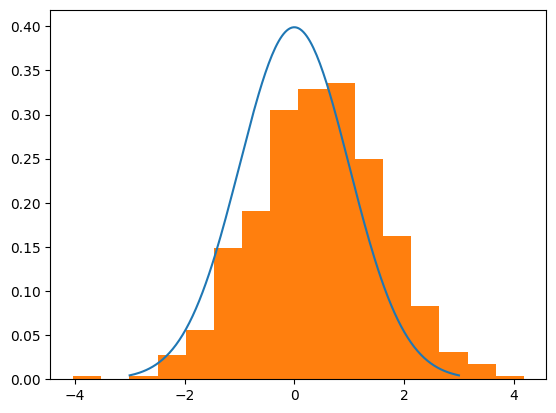

In [58]:
x = np.linspace(-3,3,200)
plt.plot(x, scipy.stats.norm.pdf(x, 0, 1))
out = plt.hist(combined_df.z_score, bins=16, density=True)

In [55]:
combined_df.z_score.describe()

count    562.000000
mean       0.443496
std        1.157664
min       -4.031970
25%       -0.312044
50%        0.449647
75%        1.184918
max        4.184025
Name: z_score, dtype: float64

Here are the most *lukewarm hands* over the past 4 seasons.

In [60]:
lukewarm_hands = combined_df.loc[(combined_df.makes > 100) & (combined_df.z_score > 2.5)].copy()
lukewarm_hands[["player_name", "makes", "z_score"]].sort_values("z_score", ascending=False)

,player_name,makes,z_score
player_id,,,
1629673,Jordan Poole,1971,4.184025
1630557,Corey Kispert,1166,3.650219
1629029,Luka Dončić,2625,3.601328
203944,Julius Randle,2020,3.587408
1630178,Tyrese Maxey,2037,3.584529
1631101,Shaedon Sharpe,981,3.177168
1629639,Tyler Herro,1963,3.066603
2544,LeBron James,2585,3.013821
1627814,Damion Lee,396,2.971641


And here are the *hot hands*.

In [9]:
hot_hands = combined_df.loc[(combined_df.makes > 100) & (combined_df.z_score < -2)].copy()
hot_hands[["player_name", "makes", "z_score"]].sort_values("z_score", ascending=True)

,player_name,makes,z_score
player_id,,,
1626158,Richaun Holmes,425,-4.031970
1630314,Brandon Williams,223,-2.968918
203991,Clint Capela,1291,-2.392061
1630558,Davion Mitchell,902,-2.277522
1629052,Oshae Brissett,418,-2.163892
1630174,Aaron Nesmith,831,-2.126050
1631104,Blake Wesley,252,-2.070078
1628983,Shai Gilgeous-Alexander,2837,-2.040083


There are far more *lukewarm hands* than *hot hands*.

In [10]:
sum(combined_df.z_score > 2)

48

In [11]:
sum(combined_df.z_score < -2)

9

We'd expect there to be about 13 players with a z score greater than 2. Instead there are 48.

In [12]:
scipy.stats.norm.cdf(-2) * len(combined_df)

np.float64(12.785574154876711)

Assuming the distribution is normal and the mean is 0, we'd expect the outliers in both directions to be equally likely, so the 48-9 split is highly unusual.

In [13]:
scipy.stats.chisquare([48,9]).pvalue

np.float64(2.3957122914850285e-07)

As with the single season data, there's a pretty strong trend where the z-score (un-streakiness) goes up as the number of makes goes up.

The blue line is the trend line. The two red lines are at -2 and +2. We'd expect there to be as many dots > 2 as < -2. clearly that's not the case. And most of the outliers in the negative direction (the "hot hands") are at a low volume of makes.

The only *streaky* player at high volume in this 4 year window is Shai Gilgeous-Alexander, with a z-score of -2.04.

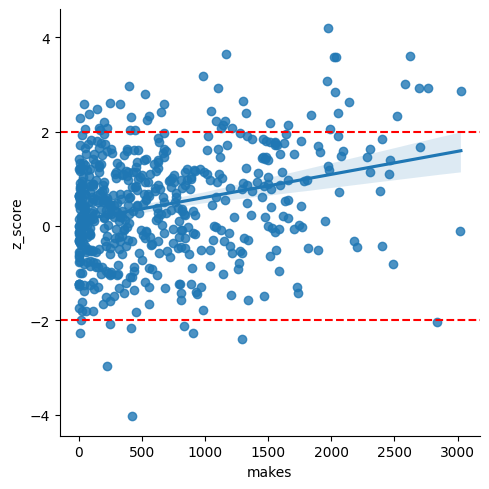

In [14]:
out = sns.lmplot(combined_df, x='makes', y='z_score')
out.ax.axhline(-2, c="r", ls="--")
out.ax.axhline(2, c="r", ls="--")

It's even clearer if I restrict it to players with over 500 makes.

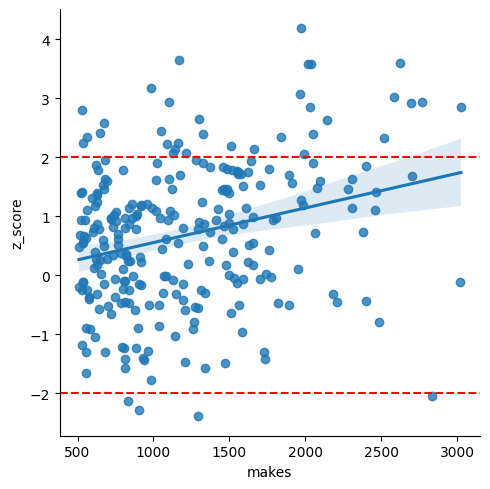

In [15]:
high_volume = combined_df[combined_df.makes > 500]

out = sns.lmplot(high_volume, x='makes', y='z_score')
out.ax.axhline(-2, c="r", ls="--")
out.ax.axhline(2, c="r", ls="--")


In [16]:
high_volume.makes.corr(high_volume.z_score)

np.float64(0.27668618294801045)

The distribution of the z scores is normal-ish. It's just not centered at 0, and the standard deviation is greater than 1.

In [17]:
scipy.stats.shapiro(high_volume.z_score).pvalue

np.float64(0.7888158478998424)

In [59]:
high_volume.z_score.describe()

count    265.000000
mean       0.680097
std        1.217946
min       -2.392061
25%       -0.149211
50%        0.776917
75%        1.485595
max        4.184025
Name: z_score, dtype: float64

Curious.

### What about streak lengths?

Let's say we look at the length of every streak of makes for every player.

We can then simulate every player's results and track the streak lengths in the simulated data. 
What does the difference between the expected streak frequencies and the actual frequencies look like?

This isn't totally scientific. Each time we generate the fake data, it will be a tiny bit different. But it should give us a sense of how actual player data differs from flipping coins.


In [ ]:
def get_streaks(some_df, type="make"):

    actual_streaks = pd.Series()
    fake_streaks = pd.Series()

    for player_id in some_df.index:
        current_raw_data = some_df.loc[player_id, 'raw_data']
        if type == "make":
            current_lengths = sp.get_make_lengths(current_raw_data)
            key = "make_lengths"
        else:
            current_lengths = sp.get_miss_lengths(current_raw_data)
            key = "miss_lengths"

        actual_streaks = actual_streaks.add(current_lengths, fill_value=0)
        
        
        makes = some_df.loc[player_id, 'makes']
        misses = some_df.loc[player_id, 'misses']
        # I'm creating an array with the same number of makes and misses as the original
        # and then shuffling it.
        fake_results = [1 for x in range(makes)] + [0 for x in range(misses)]
        rng.shuffle(fake_results)

        # alternate approach: simulate the results with the same shooting percentage as original
        # attempts = makes + misses
        # shoot_pct = makes / attempts
        # fake_results = (rng.random(attempts) < shoot_pct).astype("float")

        fake_streak_data = sp.convert_to_streaks(pd.Series(fake_results))
        
        fake_streaks = fake_streaks.add(fake_streak_data[key], fill_value=0)

    return (actual_streaks, fake_streaks)

In [41]:
def gen_results(some_df, type="make"):
    (actual_streaks, fake_streaks) = get_streaks(some_df, type)

    count_diffs = actual_streaks.subtract(fake_streaks, fill_value=0) 

    percent_diffs = count_diffs / fake_streaks

    ret = pd.DataFrame({'actual': actual_streaks, 'predicted': fake_streaks, 
                        'count_diff': count_diffs, 'percent_diff': percent_diffs})
    ret.index.name='streak length'

    ret['in_a_row'] = ret.index
    
    return ret

### Streak Lengths

Here are the differences between the actual streaks of makes and the fake ones. Streaks of 1 and 2 are more frequent in the actual shot data than the simulated shot data. Streaks of 4-9 are less frequent in the actual shot data.

The longer the streak, the less likely it is to happen. Streaks longer than 10 are extremely uncommon, so the results are too noisy to be meaningful. The big thing to notice here is that streaks of 1 and 2 are the most common, and are happening more frequently than they should by chance.

In [42]:
streak_results = gen_results(combined_df)

In [43]:
streak_results[0:10]

,actual,predicted,count_diff,percent_diff,in_a_row
streak length,,,,,
1,105890.0,103336.0,2554.0,0.024715,1
2,49498.0,48319.0,1179.0,0.0244,2
3,22795.0,22905.0,-110.0,-0.004802,3
4,10705.0,10847.0,-142.0,-0.013091,4
5,4904.0,5216.0,-312.0,-0.059816,5
6,2337.0,2521.0,-184.0,-0.072987,6
7,1144.0,1284.0,-140.0,-0.109034,7
8,652.0,662.0,-10.0,-0.015106,8
9,289.0,337.0,-48.0,-0.142433,9


Restricting to just high volume shooters doesn't change much.

In [44]:
make_results = gen_results(high_volume)

In [47]:
make_results[0:10]

,actual,predicted,count_diff,percent_diff,in_a_row
streak length,,,,,
1,89810.0,87834.0,1976.0,0.022497,1
2,42335.0,41360.0,975.0,0.023574,2
3,19664.0,19645.0,19.0,0.000967,3
4,9294.0,9167.0,127.0,0.013854,4
5,4260.0,4625.0,-365.0,-0.078919,5
6,2040.0,2179.0,-139.0,-0.063791,6
7,1011.0,1117.0,-106.0,-0.094897,7
8,564.0,587.0,-23.0,-0.039182,8
9,245.0,342.0,-97.0,-0.283626,9


Streaks of misses behave similarly to the makes. Streaks of 1-2 misses are more common in actual shot data than expected, streaks longer than that are less common than expected.

In [30]:
miss_results = gen_results(high_volume, "miss")

In [38]:
miss_results['in_a_row'] = miss_results.index

In [49]:
miss_results.loc[0:12]

,actual,predicted,count_diff,percent_diff,in_a_row
1,81349.0,79806.0,1543.0,0.019334,1
2,42404.0,41088.0,1316.0,0.032029,2
3,21792.0,21825.0,-33.0,-0.001512,3
4,11384.0,11394.0,-10.0,-0.000878,4
5,5922.0,6082.0,-160.0,-0.026307,5
6,3093.0,3228.0,-135.0,-0.041822,6
7,1679.0,1786.0,-107.0,-0.05991,7
8,919.0,928.0,-9.0,-0.009698,8
9,485.0,550.0,-65.0,-0.118182,9
10,289.0,306.0,-17.0,-0.055556,10


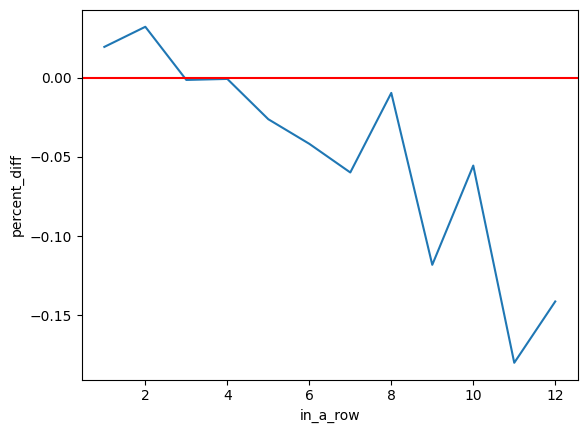

In [48]:
chart = sns.lineplot(x=miss_results.loc[0:12].in_a_row, y=miss_results.loc[0:12].percent_diff)
chart.axhline(0, color='r')

### Now What?

Although I think I've successfully discounted the notion of the hot hand, at least as a league-wide phenomenon, I still haven't explained where the bias towards un-streakiness is coming from.

It's interesting to think about how to pin down which shots are responsible for the un-streakiness, though I don't know if it's really possible. But thinking about it led me to a common-sense explanation of the unstreakiness.

If a player has missed a bunch of shots in a row, perhaps they will tend to take easier/higher percentage shots than usual. They're going to pass the ball or drive to the hoop instead of taking a long contested shot, for instance. We might pretend for the sake of simplicity that every shot has the same chances of going in, but that's not reality. Some shots are easier than others, and players can choose which shots they take.

The same could go for a player who has made a bunch of shots in a row. Perhaps they are taking riskier/harder/lower percentage shots than usual -- the "heat check" moment where a player takes shots they usually wouldn't because they're on a *hot streak*.

I'm also interested in if shooting percentages change throughout the game.  For instance, what is the percentage on the first shot of the game for a player versus the 10th? How do breaks in the action (times a player gets subbed out, or breaks between games) affect streakiness? If a player's last shot of the game is more likely to be a make than usual, and the first one to be a miss, that will lead to extra streaks.

Imagine if we went through and flipped each shot in a sequence, one by one. Change each made shot to a missed shot, or vice versa, then recalculate the number of streaks. Each shot can increase/decrease the streak count by 2, or 0. I'm interested in the shots where flipping them would decrease the streak count (in other words, lead to longer streaks and more coin-like behavior). These are the shots that are potentially responsible for the inflated numbere of streaks. When do these high leverage shots occur? 

* W *L* W  <- streak count is 3, would be 1 if the "L" was flipped
* L *L* W  <- streak count is 2, would stay 2 if flipped
* W *L* L  <- streak count is 2, would stay 2 if flipped
* L *L* L  <- streak count is 1, would be 3 if flipped

The most un-streaky player over a 4 year stretch was Jordan Poole.

In [51]:
poole = lukewarm_hands.loc[1629673]

In [52]:
poole.total_streaks - poole.expected_streaks

np.float64(138.8075999126445)

In [54]:
poole.makes + poole.misses

np.int64(4579)

In [56]:
70 / 4579

0.015287180607119458

Each shot can alter the streak count by at most 2. So we'd be looking for around 70 shots out of 4579 total shots. That's not a lot.

Rather than looking at individual players, I'll have to look at all the shots in aggregate because there is no way of knowing how much of the un-streakiness for a particular player is "organic" (caused by the randomness of the universe) and how much is "artificial" (caused by the player). 